# House Prices

This project is to explore the house features (independent variables) of the data set `train` taken from [Kaggle](https://www.kaggle.com) and build a model using the $SalePrice$ (dependent variable) given in the same data set. The model will then be used to predict the $SalePrice$ of the houses given in the `test` data set and submitted to Kaggle who have the actual
$SalePrice$ of these houses.

## Required Python Modules
1. `numpy`
1. `pandas`
1. `matplotlib`
1. `seaborn`
1. `scipy`
1. `sklearn`

## Import the data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold
import warnings

HousesSold = pd.read_csv('data/train.csv', index_col = 'Id')
print(HousesSold.shape)
print(list(HousesSold.columns))

(1460, 80)
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Po

There are 81 variables in total in this data set and a total of 1460 observations.
## Missing values

It is important that we remove the variables with the significant number of missing values.

In [2]:
allMissing = HousesSold.isnull().sum().sort_values(ascending=False)
percentage = (HousesSold.isnull().sum()/HousesSold.isnull().count()).sort_values(ascending=False)
missingData = pd.concat([allMissing, percentage*100], axis=1, keys=['TotalMissing', 'Percentage'])
missingData.head(20)

,TotalMissing,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageCond,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


It is not a bad idea to drop the variables $PoolQC$, $MiscFeature$, $Alley$, $Fence$, $FireplaceQu$, and $LotFrontage$ that have 17% or more missing observations. We will think of dealing with the missing values in the remaining variables as we need to deal with them.

In [3]:
HousesSold.drop(labels = ['PoolQC' , 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
                , axis = 1, inplace = True)

### Variable types
We notice that the variable $MSSubClass$ is indeed a _categorical_ variable but has been import as an _integer_ column in `pandas`. We can fix that with

In [4]:
HousesSold['MSSubClass'] = HousesSold['MSSubClass'].apply(str)

## Correlations

Variables that are numeric and are strongly correlated with $SalePrice$ variable can be spotted from the heat map of their correlations with each other.

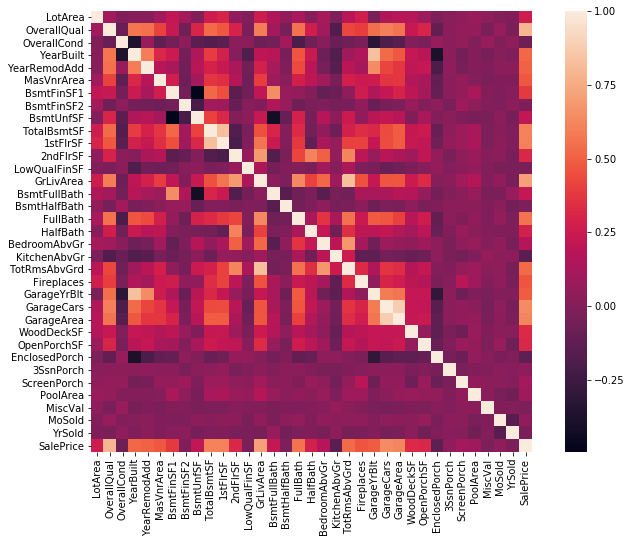

In [5]:
corrmat = HousesSold.corr()
f2=plt.subplots(1, figsize=(12, 9))

sb.heatmap(corrmat, vmax=1.0, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2)
plt.show()

We can pick the better correlated variables with the $SalePrice$ from the list of all numeric variables as follows

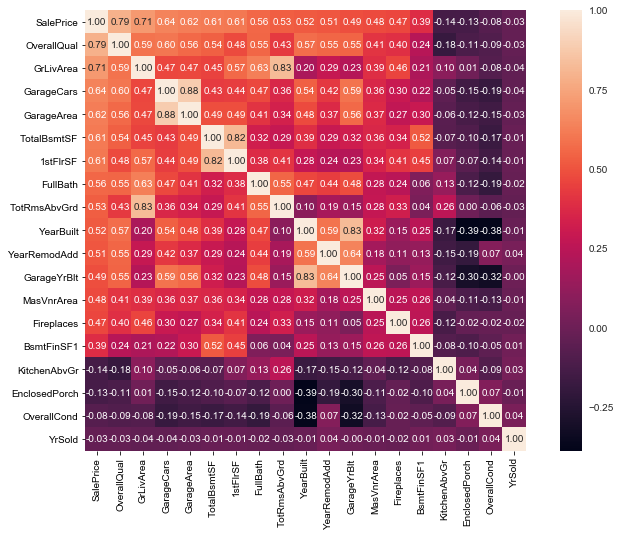

In [6]:
k_pos = 15
k_neg = 4
cols_pos = list(corrmat.nlargest(k_pos, 'SalePrice')['SalePrice'].index)
cols_neg = list(corrmat.nsmallest(k_neg, 'SalePrice')['SalePrice'].index)
cm = HousesSold[cols_pos + cols_neg].corr()
f3=plt.subplots(1, figsize=(12, 9))
sb.set(font_scale=1)
sb.heatmap(cm, cbar=True, annot = True, square=True, fmt='.2f'
           , annot_kws={'size': 10}, yticklabels=cols_pos + cols_neg, xticklabels=cols_pos + cols_neg)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.subplots_adjust(bottom=0.2)
plt.show()

Thus, we observe that the variable $SalePrice$ has some correlation with the following variables:

 1. $OverallQual$
 1. $GrLivArea$
 1. $GarageCars$
 1. $GarageArea$
 1. $TotalBsmtSF$
 1. $1stFlrSF$
 1. $FullBath$
 1. $TotRmsAbvGrd$
 1. $YearBuilt$
 1. $YearRemodAdd$
 1. $GarageYrBlt$
 1. $MasVnrArea$
 1. $Fireplaces$
 1. $BsmtFinSF1$
 1. $KitchenAbvGr$
 1. $EnclosedPorch$
 1. $OverallCond$

It is obvious that the variables $GarageArea$ and $GarageCars$ are strongly correlated with each other. Similarly, $GrLivArea$ and $TotRmsAbvGrd$ are strongly correlated and so are the variables $GarageYrBlt$ and $YearBuilt$. We can use `LinearRegression` model of the `linear_model` class to pick the the variables out of this subset that can explain the $SalePrice$.

In [7]:
better_corr_num = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'
                        , 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea'
                        , 'Fireplaces', 'BsmtFinSF1', 'KitchenAbvGr', 'EnclosedPorch', 'OverallCond']
HousesSold = HousesSold[better_corr_num + HousesSold.select_dtypes(exclude=[np.number]).columns.tolist() + ['SalePrice']]

We notice that the variables $GarageYrBlt$ and $MasVnrArea$ have some missing values and these variables have some correlation with the reponse variable $SalePrice$. It seems sensible to replace missing values of $GarageYrBlt$ with zero as these are the houses that have no garage. It will, therefore, be good to remove the impact of year variable when the garage was built. Similarly, the houses that have missing $MasVnrArea$ are the ones that have no masonary veneer and it is okay to fill zeros for these. Also we are good to remove the other columns that have missing values except $Electrical$.

In [8]:
HousesSold['GarageYrBlt'].fillna(0, inplace = True)
HousesSold['MasVnrArea'].fillna(0, inplace = True)
HousesSold.drop(labels = ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual', 'BsmtFinType2'
                          , 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType']
                , axis = 1, inplace = True)
HousesSold = HousesSold.dropna(axis=0, subset=['Electrical'])

### Exploratory data analysis
#### Numerical variables

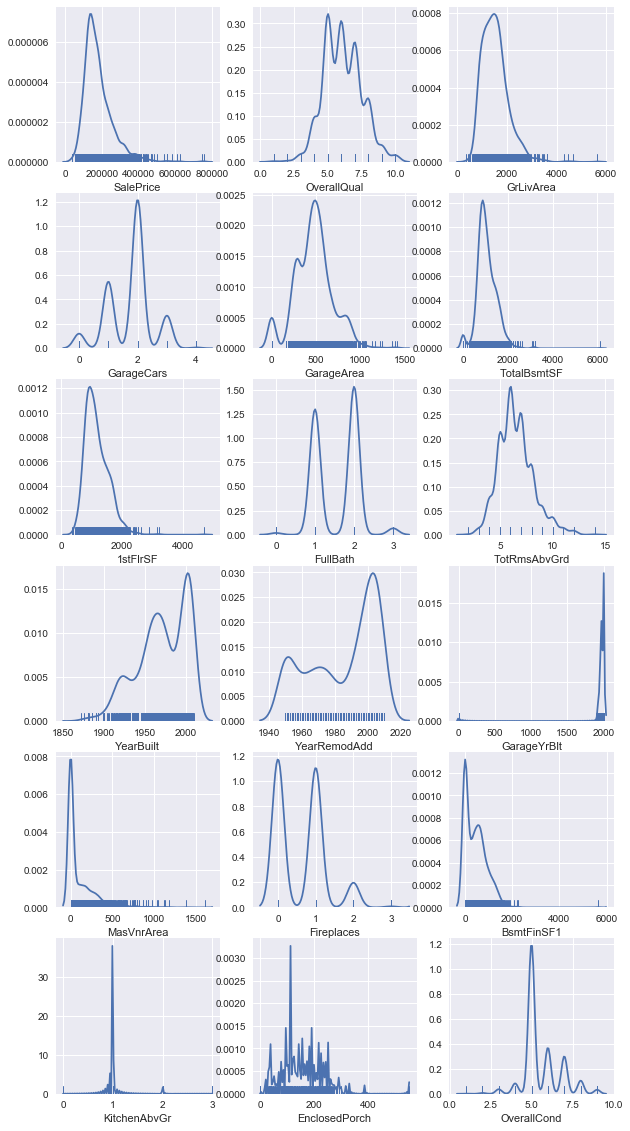

In [9]:
f, axes = plt.subplots(figsize=(10,20), ncols=3, nrows=6)
for i, col in enumerate(['SalePrice']+better_corr_num):
    sb.distplot(HousesSold[[col]], hist=False, rug=True, ax = axes[divmod(i, 3)[0]][i % 3])
    axes[divmod(i, 3)[0]][i % 3].set_xlabel(col)
plt.show()

The response variable $SalePrice$ is right-skewed and can perhaps be transformed to have approximately normal shape with a _log_ transformation. Similarly, the variables $GrLivArea$ and $1stFlrSF$ can transformed with a _log_ transformation to have an approximately normal shape.

The variables $GarageArea$, $TotalBsmtSF$, $MasVnrArea$, and $BsmtFinSF1$ are also right-skewed but a _log_ transformation can not be applied on these for some zero values. We will apply _fourth root_ on these to make them approximately normal, except that there will be a peak at zeros. We plot the above figure after these transformations.

We will apply a _third exponent_ transformation on the $YearBuilt$ variable to make this approximately normal, if possible.

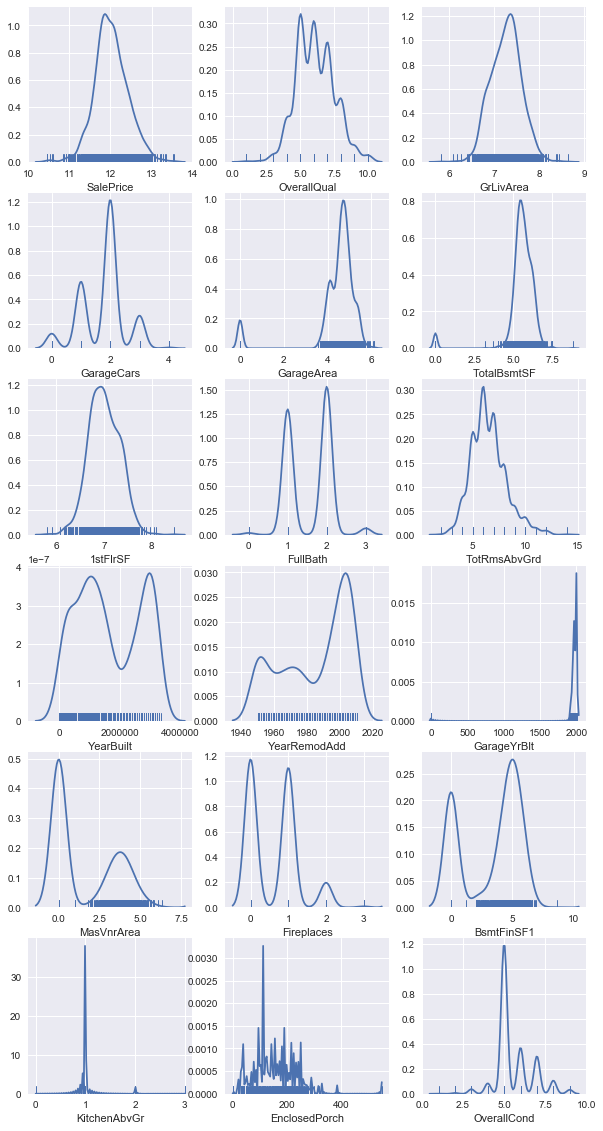

In [10]:
log_trans = ['SalePrice', 'GrLivArea', '1stFlrSF']
one_fourth = ['GarageArea', 'TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1']

for col in log_trans:
    HousesSold[col] = np.log(HousesSold[col])

for col in one_fourth:
    HousesSold[col] = np.power(HousesSold[col], 0.25)
HousesSold['YearBuilt'] = np.power(HousesSold['YearBuilt']-1860, 3)
        
f, axes = plt.subplots(figsize=(10,20), ncols=3, nrows=6)
for i, col in enumerate(['SalePrice']+better_corr_num):
    sb.distplot(HousesSold[[col]], hist=False, rug=True, ax = axes[divmod(i, 3)[0]][i % 3])
    axes[divmod(i, 3)[0]][i % 3].set_xlabel(col)
plt.show()

In [11]:
lr = linear_model.LinearRegression()
lr.fit(HousesSold[better_corr_num], HousesSold['SalePrice'])

mse = mean_squared_error(HousesSold['SalePrice'], lr.predict(HousesSold[better_corr_num]))
print(mse)

0.0203205324325


In [12]:
y = HousesSold['SalePrice']
cats_list = HousesSold.select_dtypes(exclude=[np.number]).columns.tolist()
master_cats = {}

for j in range(15):
    cats_impr = {}
    for col in cats_list:
        X = pd.get_dummies(HousesSold[better_corr_num + list(master_cats.keys()) + [col]], drop_first = True)
        lr.fit(X, y)
        cats_impr[col] = mean_squared_error(y, lr.predict(X))
    best_col = min(cats_impr, key=cats_impr.get)
    master_cats[best_col] = cats_impr[best_col]
    cats_list.remove(best_col)

for key, value in sorted(master_cats.items(), key=lambda item: (item[1], item[0]), reverse = True):
    print ("%s: %s" % (key, value))

Neighborhood: 0.0168879068731
RoofMatl: 0.0154436089354
MSZoning: 0.014663136469
Functional: 0.0140002499874
MSSubClass: 0.013522836935
Condition2: 0.0130696424947
Exterior1st: 0.012621564239
KitchenQual: 0.0122553127147
Condition1: 0.0119106263525
SaleCondition: 0.0116235116405
Heating: 0.0114277409497
LotConfig: 0.0112385869967
SaleType: 0.0110931724535
Foundation: 0.0109800213323
HeatingQC: 0.0108681427405


Let's use the following categorical variables in our model:
1. $Neighborhood$
1. $RoofMatl$
1. $MSZoning$
1. $Functional$
1. $MSSubClass$
1. $Condition2$
1. $Exterior1st$
1. $KitchenQual$
1. $Condition1$
1. $SaleCondition$
1. $Heating$
1. $LotConfig$


Now we use the numerical and categorical variables identified above to build and tune the model.
## Optimum $k$ of cross validation
To find out the optimum folds of K Fold cross validation we execute the following experiment:

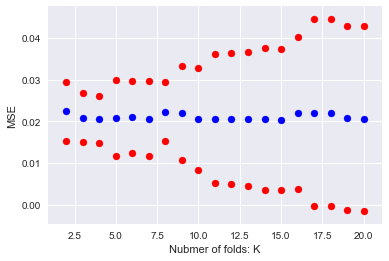

In [13]:
better_corr_cat = ['Neighborhood', 'RoofMatl', 'MSZoning', 'Functional', 'MSSubClass', 'Condition2'
                   , 'Exterior1st', 'KitchenQual', 'Condition1', 'SaleCondition', 'Heating', 'LotConfig']
HousesSold = HousesSold[better_corr_num + better_corr_cat + ['SaleType']]
X = pd.get_dummies(HousesSold[better_corr_num + better_corr_cat], drop_first = True)
k_vals = []
mse_u = []
mse_l = []
mse_m = []
for k in range(2, 21):
    mod_crossval = linear_model.LinearRegression()
    scores = -cross_val_score(mod_crossval, X, y, cv=k, scoring = 'neg_mean_squared_error')
    k_vals.append(k)
    mse_u.append(scores.mean() + scores.std() * 2)
    mse_l.append(scores.mean() - scores.std() * 2)
    mse_m.append(scores.mean())
    
plt.scatter(k_vals, mse_m, c = 'b')
plt.scatter(k_vals, mse_l, c = 'r')
plt.scatter(k_vals, mse_u, c = 'r')
plt.xlabel('Nubmer of folds: K')
plt.ylabel('MSE')
plt.show()


This suggests that a 5 to 10 folds cross validation is good for this data set. Any lower $k$ results in training data sets to of smaller size and for $k>10$, test sets are very small and there is greater dispersion in their scores. We will pick a $k$ value of 10 for this project to tune our models.

## The model
We want to try Elastic Net model which is usual GLM but has a loss funtion that is a combination of ordinary least squared error term plus a penalty term. This penalty term is a blend of norm of coefficients of type 1 and 2. We will have to optimize the hyperparameters of the model. There are two hyperparameters that help tune the model.

In [14]:
alpha = np.linspace(0.0001, 0.8, 10)
l1_ratio = np.linspace(0, 1, 10)
hyperparameters = dict(alpha=alpha, l1_ratio=l1_ratio)
lr = linear_model.ElasticNet(max_iter = 10000, tol = 0.001)
cv = RepeatedKFold(n_splits=10, n_repeats=3)
grid_lr = GridSearchCV(lr, hyperparameters, cv=cv, verbose=0, scoring = 'neg_mean_squared_error', return_train_score = True)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_lr.fit(X, y)

In [15]:
print('Best parameters:', grid_lr.best_estimator_.get_params())
print('Best Score:', grid_lr.best_score_)

Best parameters: {'alpha': 0.0001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1.0, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': False}
Best Score: -0.0172346068724


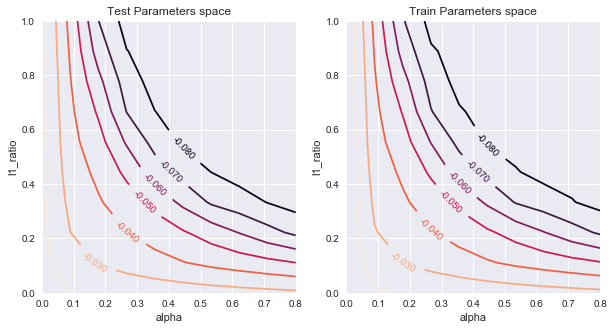

In [16]:
f, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
test_scores = grid_lr.cv_results_['mean_test_score'].reshape(len(alpha), len(l1_ratio))
train_scores = grid_lr.cv_results_['mean_train_score'].reshape(len(alpha), len(l1_ratio))
param_alpha = grid_lr.cv_results_['param_alpha'].reshape(len(alpha), len(l1_ratio))
param_l1_ratio = grid_lr.cv_results_['param_l1_ratio'].reshape(len(alpha), len(l1_ratio))
CS = axes[0].contour(param_alpha, param_l1_ratio, test_scores)
plt.clabel(CS, inline=1, fontsize=10)
axes[0].set_title('Test Parameters space')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('l1_ratio')

CS1 = axes[1].contour(param_alpha, param_l1_ratio, train_scores)
plt.clabel(CS1, inline=1, fontsize=10)
axes[1].set_title('Train Parameters space')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('l1_ratio')
plt.show()

This suggests that the optimum value of $\alpha$ (alpha) is very small, or a very small regularization is needed. Let's apply this set of optimum parameters set to fit the final model on the entire data set and use this to predict the house prices of the `test` data set.